{'textcat': 16.978405237197876}
{'textcat': 3.019945802167058}
{'textcat': 1.6525662876665592}
{'textcat': 1.2708395158406347}
Treinamento concluído!


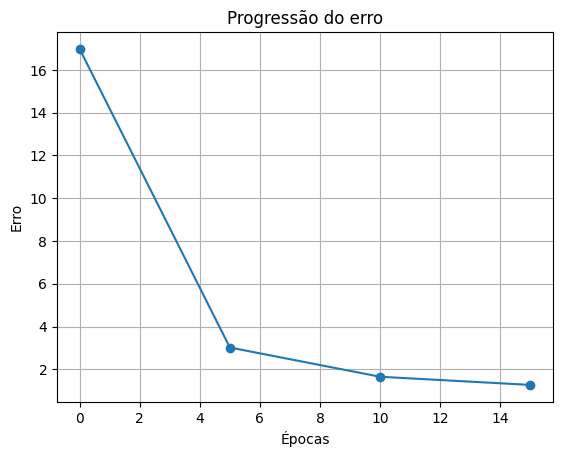

0.98992
Acurácia: 98.99%


In [ ]:
import pandas as pd
import spacy
import re
import random
from spacy.training import Example
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score  # Importar a função para calcular a precisão

# Carregar o modelo do spaCy
nlp = spacy.load("en_core_web_sm")

# Ler o CSV com pandas, usando ponto e vírgula como delimitador
test = pd.read_csv("Train50.csv", delimiter=';', encoding='utf-8')

# Remover colunas desnecessárias
test.drop(['id', 'tweet_date', 'query_used'], axis=1, inplace=True)

# Função para limpar e lematizar o texto
def clean_text(text):
    text = text.lower()
    text = re.sub(r"@[A-Za-z0-9$-_@.&+]+", ' ', text)  # Remove menções (@username)
    text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)  # Remove links
    text = re.sub(r"[^a-zA-Z0-9\s]", ' ', text)  # Remove caracteres especiais
    text = re.sub(r"\s+", ' ', text)  # Remove espaços em branco

    # Processar o texto com spaCy
    doc = nlp(text)

    # Filtrar stop words e pontuação, e lematizar os tokens
    filtered_tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]

    # Juntar tokens em uma string
    return ' '.join(filtered_tokens)

# Aplicar a função de limpeza em cada linha da coluna 'tweet_text'
test['tweet_text'] = test['tweet_text'].apply(clean_text)

# Criar a base de dados final com textos e emoções
base_dados_final = []
for texto, emocao in zip(test['tweet_text'], test['sentiment']):
    if emocao == 1:
        dic = {'POSITIVO': True, 'NEGATIVO': False}
    elif emocao == 0:
        dic = {'POSITIVO': False, 'NEGATIVO': True}
    base_dados_final.append([texto, dic.copy()])

# Criar um novo modelo de classificação de texto
modelo = spacy.blank("en")  # Cria um modelo em branco

# Adicionar o componente TextCategorizer ao pipeline
text_classifier = modelo.add_pipe("textcat", last=True)

# Adicionar os rótulos de categorias ao classificador
text_classifier.add_label("POSITIVO")
text_classifier.add_label("NEGATIVO")

# Inicializar o treinamento
modelo.begin_training()

# Treinar o modelo
historico = []
for epoca in range(20):
    random.shuffle(base_dados_final)
    losses = {}
    for batch in spacy.util.minibatch(base_dados_final, 512):
        textos = [modelo.make_doc(texto) for texto, entities in batch]
        annotations = [{'cats': entities} for texto, entities in batch]
        examples = [Example.from_dict(doc, annotation) for doc, annotation in zip(textos, annotations)]
        modelo.update(examples, losses=losses)
    if epoca % 5 == 0:
        print(losses)
        historico.append(losses)

# Salvar o modelo treinado
modelo.to_disk("modelo_treinado")

print("Treinamento concluído!")

# Extrair e plotar o histórico de perda
historico_loss = [losses.get('textcat', 0) for losses in historico]
epochs = range(0, len(historico_loss) * 5, 5)  # Assumindo que você imprime o histórico a cada 5 épocas

plt.plot(epochs, historico_loss, marker='o')
plt.title('Progressão do erro')
plt.xlabel('Épocas')
plt.ylabel('Erro')
plt.grid(True)
plt.show()

# Carregar o modelo treinado
modelo_carregado = spacy.load("modelo_treinado")

# Fazer previsões nos dados de teste
previsoes = []
for texto in test['tweet_text']:
    doc = modelo_carregado(texto)
    previsoes.append(doc.cats)

# Converter as previsões em rótulos (1 para POSITIVO, 0 para NEGATIVO)
previsoes_final = []
for previsao in previsoes:
    if previsao['POSITIVO'] > previsao['NEGATIVO']:
        previsoes_final.append(1)
    else:
        previsoes_final.append(0)

# Converter para numpy array
previsoes_final = np.array(previsoes_final)

# Obter as respostas reais do conjunto de dados
respostas_reais = test['sentiment'].values

# Calcular a precisão
precisao = accuracy_score(respostas_reais, previsoes_final)

print(precisao)
print(f"Acurácia: {precisao * 100:.2f}%")